In [1]:
import numpy as np
import pandas as pd
import pylab as plt
%matplotlib inline

### RankingFactorizationRecommender

In [2]:
import graphlab

In [3]:
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr

def print_metrics(model, name):
    all_user_id_test = np.unique(df_pair_user_film_test.user_id)
    list_mse = []
    list_SPR = []

    for user_id in all_user_id_test:
        tmp = df_pair_user_film_test[df_pair_user_film_test['user_id'] == user_id]
        user_id_list = list(tmp.user_id)
        item_id_list = list(tmp.element_id)

        if (len(item_id_list) <= 1):
            continue
        y_test = list(tmp.score)
        sf_test = graphlab.SFrame({'user_id': user_id_list,
                                   'item_id': item_id_list})
        y_pred = model.predict(sf_test)    
        y_pred = list(y_pred)

        MSE = mean_squared_error(y_test, y_pred)
        list_mse.append(MSE)

        SPR = spearmanr(y_test, y_pred)  

        if (np.isnan(SPR[0])):
            y_test.append(1)
            y_pred.append(1)
            SPR = spearmanr(y_test, y_pred) 

        list_SPR.append(SPR[0])

        
    m1 = np.average(list_mse)
    m2 = np.average(list_SPR)
    m3 = mean_average_precision(model, df_pair_user_film_test)
    print name    
    print "MSE:", m1
    print "Spearman:", m2
    print "MAP:", m3
    return m1, m2, m3

In [4]:
def average_precision_score(predicted_rating, movieID_test, min_score=5):
    """
    Parameters
    ----------
    predicted_rating : отсортированный по убыванию список пар (movie_ID, pred_score)
    movieID_test : список movie_ID для теста
    min_score : минимальный score, фильм которого считется релевантым
    -------
    average precision
    """
    list_of_position = []
    list_of_scores = []
    k = 1
    for row in predicted_rating:
        movie_id = row['item_id']
        score = row['score']
        if (movie_id in movieID_test):
            list_of_position.append(k) 
            list_of_scores.append(score)
        k +=1
       
    list_of_scores = np.array(list_of_scores, dtype='float32')
    list_of_position = np.array(list_of_position, dtype='float32')
    list_of_position = list_of_position[list_of_scores >= min_score]
          
    arr = 1 / list_of_position 
    N = float(len(list_of_position)) 
    AP = 1 / N * np.sum(arr)
    
    return AP    

In [5]:
def mean_average_precision(model, data_test):
    all_userIDs = np.unique(data_test.user_id)
    all_filmIDs = np.unique(data_test.element_id)
    list_of_average_precision = []
    
    for user_id in all_userIDs:
        test_user = data_test[data_test['user_id'] == user_id]
        movieID_test = test_user.element_id
        
        recs = model.recommend(users=[user_id], k=5000)
        
        try:
            AP = average_precision_score(recs, list(movieID_test), min_score=5)
        except ZeroDivisionError:
            continue
            
        if (np.isnan(AP)):
            print user_id
        list_of_average_precision.append(AP)
     
    return np.average(list_of_average_precision)    

In [6]:
df_pair_user_film_train = pd.read_csv('train_rating.csv')
df_pair_user_film_test = pd.read_csv('test_rating.csv')

In [7]:
df_pair_user_film_train.head()

,user_id,element_id,score
0,98304,1101771,9
1,16387,188463,6
2,16387,197307,10
3,16387,197531,9
4,16387,198284,7


In [8]:
user_id_list_train = list(df_pair_user_film_train.user_id)
item_id_list_train = list(df_pair_user_film_train.element_id)
rating_list_train = list(df_pair_user_film_train.score)

### Latent Factor Model

In [9]:
sf = graphlab.SFrame({'user_id': user_id_list_train,
                       'item_id': item_id_list_train,
                       'rating': rating_list_train})
m1 = graphlab.ranking_factorization_recommender.create(sf, target='rating', 
                                                       num_factors=100, 
                                                       linear_regularization=0.0001, 
                                                       ranking_regularization=0.0001)

This non-commercial license of GraphLab Create for academic use is assigned to stepamalkevich@yandex.ru and will expire on November 24, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1481276579.log


Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 14304 observations with 3673 users and 4675 items.

Data prepared in: 0.057528s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 100      |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 14304 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.3893                                   |

| 5       | 0.0488281         | 2.60523                                  |

| 6       | 0.0244141         | 3.03344                                  |

| 7       | 0.012207          | 3.55166                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.3893                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 92us         | 5.3085            | 2.30358               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 98.185ms     | 4.81357           | 2.12028               | 0.0976562   |

| 2       | 205.72ms     | 3.42019           | 1.726                 | 0.0580668   |

| 3       | 307.457ms    | 3.09676           | 1.60395               | 0.042841    |

| 4       | 398.566ms    | 2.95914           | 1.54165               | 0.0345267   |

| 5       | 519.098ms    | 2.8845            | 1.502                 | 0.029206    |

| 6       | 637.587ms    | 2.80974           | 1.46451               | 0.0254734   |

| 10      | 928.301ms    | 2.34524           | 1.26387               | 0.017366    |

| 11      | 1.01s        | 2.22997           | 1.21287               | 0.016168    |

| 20      | 1.81s        | 1.47661           | 0.827926              | 0.0103259   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.23369

Final training RMSE: 0.670012

In [106]:
print_metrics(m1, 'LFM')

LFM
MSE: 3.42808830012
Spearman: 0.374211013261
MAP: 0.00394247603879


### Latent Factor Model + implicit feedback

In [130]:
sf = graphlab.SFrame({'user_id': user_id_list_train,
                       'item_id': item_id_list_train,
                       'rating': rating_list_train})
m1 = graphlab.ranking_factorization_recommender.create(sf, target='rating', 
                                                       num_factors=100, 
                                                       linear_regularization=0.0001, 
                                                       ranking_regularization=0.0001,
                                                       ials_confidence_scaling_factor = 100,
                                                       ials_confidence_scaling_type='linear')

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 14304 observations with 3673 users and 4675 items.

Data prepared in: 0.035707s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 100      |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 14304 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.38844                                  |

| 5       | 0.0488281         | 2.6054                                   |

| 6       | 0.0244141         | 3.03361                                  |

| 7       | 0.012207          | 3.5516                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.38844                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 146us        | 5.3085            | 2.30358               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 39.206ms     | 4.80911           | 2.11932               | 0.0976562   |

| 2       | 119.388ms    | 3.42195           | 1.72675               | 0.0580668   |

| 3       | 214.821ms    | 3.09602           | 1.60378               | 0.042841    |

| 4       | 308.948ms    | 2.95899           | 1.54161               | 0.0345267   |

| 5       | 356.386ms    | 2.88203           | 1.50129               | 0.029206    |

| 6       | 424.814ms    | 2.80405           | 1.46263               | 0.0254734   |

| 11      | 733.442ms    | 2.23095           | 1.21342               | 0.016168    |

| 25      | 1.77s        | 1.27121           | 0.697513              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.23435

Final training RMSE: 0.670576

In [131]:
print_metrics(m1, 'LFM + implicit')

LFM + implicit
MSE: 3.40997803225
Spearman: 0.420400187465
MAP: 0.00342633906025


### Most Popular

In [91]:
sf = graphlab.SFrame({ 'user_id': user_id_list_train,
                       'item_id': item_id_list_train,
                       'rating': rating_list_train})

m2 = graphlab.recommender.popularity_recommender.create(sf, target='rating')

Recsys training: model = popularity

Preparing data set.

Data has 14304 observations with 3673 users and 4675 items.

Data prepared in: 0.034295s

14304 observations to process; with 4675 unique items.

In [92]:
print_metrics(m2, 'most popular')

most popular
MSE: 4.05905354705
Spearman: 0.360202440608
MAP: 0.000806315978757


### Item-based

In [311]:
sf = graphlab.SFrame({ 'user_id': user_id_list_train,
                       'item_id': item_id_list_train,
                       'rating': rating_list_train})

model = graphlab.item_similarity_recommender.create(sf, target="rating",
                                                 similarity_type='pearson')

Recsys training: model = item_similarity

Preparing data set.

Data has 14304 observations with 3673 users and 4675 items.

Data prepared in: 0.035849s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.266ms                        | 27         |

| 5.454ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 62.171ms                            | 0                | 0               |

| 263.631ms                           | 100              | 4675            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.282499s

In [312]:
print_metrics(model, 'cos model')

cos model
MSE: 4.05668279347
Spearman: 0.363025349205
MAP: 0.0007979031982


(4.05668279346843, 0.36302534920531598, 0.00079790319820004826)

### Дополнительные фичи

средняя оценка пользователя, средняя длина отзыва этого пользователя -- средняя оценка по фильму, средняя длина отзыва об этом фильме

In [52]:
sf = graphlab.SFrame({ 'user_id': user_id_list_train,
                       'item_id': item_id_list_train,
                       'rating': rating_list_train})

user_info = graphlab.SFrame({ 'user_id': all_user_id_train,
                              'tomita_dic':tomita_dic})

item_info = graphlab.SFrame({'item_id': all_film_id_train,
                              'avg_film_score_list': avg_film_score_list})

model_f2_f6 = graphlab.ranking_factorization_recommender.create(sf, num_factors=150, 
                                               target='rating',
                                               user_data=user_info,
                                               item_data=item_info, 
                                               linear_regularization=0.0001,
                                               ranking_regularization=0.0001)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 14304 observations with 3673 users and 4675 items.

Data prepared in: 0.06016s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 150      |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.0001   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 14304 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 12.5              | Not Viable                               |

| 1       | 3.125             | Not Viable                               |

| 2       | 0.78125           | Not Viable                               |

| 3       | 0.195312          | Not Viable                               |

| 4       | 0.0488281         | Not Viable                               |

| 5       | 0.012207          | No Decrease (11.094 >= 5.28369)          |

| 6       | 0.00305176        | 3.43447                                  |

| 7       | 0.00152588        | 4.22987                                  |

| 8       | 0.000762939       | 4.71374                                  |

| 9       | 0.00038147        | 5.00327                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00305176        | 3.43447                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 120us        | 5.30747           | 2.30335               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 151.627ms    | 4.64146           | 2.15388               | 0.00305176  |

| 2       | 287.372ms    | 4.08074           | 2.01948               | 0.00305176  |

| 3       | 419.222ms    | 3.87176           | 1.96703               | 0.00305176  |

| 4       | 564.228ms    | 3.84535           | 1.96027               | 0.00305176  |

| 5       | 701.32ms     | 3.86692           | 1.96574               | 0.00305176  |

| 6       | 826.137ms    | 3.76717           | 1.94017               | 0.00305176  |

| 10      | 1.39s        | 2.92413           | 1.70906               | 0.00305176  |

| 11      | 1.51s        | 2.77477           | 1.66476               | 0.00305176  |

| 20      | 2.50s        | 2.57174           | 1.60248               | 0.00305176  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.57715

Final training RMSE: 1.89023

In [504]:
print_metrics(m4, "FM: f1 + f2")

FM: f1 + f2
MSE: 3.47139492354
Spearman: 0.378060459738
MAP: 0.00348425980214


In [502]:
print_metrics(m4, "FM: f1 + f2 + implicit")

FM: f1 + f2
MSE: 3.43930488796
Spearman: 0.421442374839
MAP: 0.00332006174286


In [238]:
print_metrics(m4, 'FM: f1 + f2 + f5')

FM: f1 + f2 + f5
MSE: 4.4779051856
Spearman: 0.00640136036089
MAP: 0.000920439860728


In [240]:
print_metrics(m4, 'FM: f5')

FM: f5
MSE: 4.58118757217
Spearman: 0.2339765287
MAP: 0.00197088116938


In [33]:
print_metrics(m4, 'FM: f5')

FM: f6
MSE: 5.4146844512
Spearman: 0.00837842885238
MAP: 0.00156554559825


In [365]:
print_metrics(m4, 'FM: f5 + f6')

FM: f5 + f6
MSE: 4.01182655808
Spearman: 0.181831266313
MAP: 0.00138985484722


In [368]:
print_metrics(m4, 'FM: f1 + f2 + f5 + f6')

FM: f1 + f2 + f5 + f6
MSE: 11.3771853103
Spearman: -0.0193952694649
MAP: 0.000676504009648


In [370]:
print_metrics(m4, 'FM: f1 + f6')

FM: f1 + f6
MSE: 4.22737299536
Spearman: 0.206670915633
MAP: 0.00188084841244


In [519]:
print_metrics(m4, 'FM: f1 + f2 + f7')

FM: f1 + f2 + f7
MSE: 4.83851759742
Spearman: 0.230951028372
MAP: 0.00128956539023


In [36]:
print_metrics(m4, 'FM: f1 + f2 + f5')

FM: f1 + f2 + f5
MSE: 4.52543638995
Spearman: 0.021457100992
MAP: 0.000888197534897


In [92]:
print_metrics(m4, 'FM: f1 + f2 + f7')

FM: f1 + f2 + f7
MSE: 3.64885915238
Spearman: 0.349695358021
MAP: 0.00176216498326


In [109]:
print_metrics(m4, 'FM: f1 + f2 + f8')

FM: f1 + f2 + f8
MSE: 4.38681066302
Spearman: 0.0861404836018
MAP: 0.00107660671052


In [111]:
print_metrics(m4, 'FM: f8')

FM: f8
MSE: 6.38055782474
Spearman: 0.0372681135133
MAP: 0.00104091405678


In [123]:
print_metrics(m4, 'FM: f9') #MAP: 0.00378881156487 при только f9 и num_factors=150

FM: f9
MSE: 3.8108740182
Spearman: 0.138681716988
MAP: 0.00378881156487


In [133]:
print_metrics(m4, 'FM: f10')

FM: f10
MSE: 5.01897340597
Spearman: 0.277056665598
MAP: 0.000665904796529


In [131]:
print_metrics(m4, 'FM: f9 + f10')

FM: f9 + 10
MSE: 4.26071888566
Spearman: 0.114757217522
MAP: 0.000503996060418


In [136]:
print_metrics(m4, 'FM: f1 + f2 + f9 + f10')

FM: f1 + f2 + f9 + f10
MSE: 3.90633399485
Spearman: 0.255866209051
MAP: 0.000702769630751


In [140]:
print_metrics(m4, 'FM: f11')

FM: f11
MSE: 3.50780044494
Spearman: 0.290736556305
MAP: 0.00586620594892


In [51]:
print_metrics(m4, "FM: f2 + f6")

FM: f2 + f6
MSE: 3.41728485201
Spearman: 0.439249617231
MAP: 0.000967072767714


(3.4172848520059822, 0.43924961723100403, 0.00096707276771442418)

### Итоговая модели FM f2 + f6

In [53]:
print_metrics(model_f2_f6, "FM: f2 + f6")

FM: f2 + f6
MSE: 4.78362017632
Spearman: 0.304981927763
MAP: 0.00560577763377


(4.7836201763205333, 0.30498192776288507, 0.0056057776337726803)

In [106]:
result_dic = {}

all_user_id_test = np.unique(df_pair_user_film_test.user_id)
for user_id in all_user_id_test:
    tmp = df_pair_user_film_test[df_pair_user_film_test['user_id'] == user_id]
    user_id_list = list(tmp.user_id)
    item_id_list = list(tmp.element_id)
    if (len(item_id_list) <= 1):
            continue
    y_test = list(tmp.score)
    sf_test = graphlab.SFrame({'user_id': user_id_list,
                               'item_id': item_id_list})
    y_pred = model_f2_f6.predict(sf_test)    
    y_pred = list(y_pred)
    SPR = spearmanr(y_test, y_pred)
    if (np.isnan(SPR[0])):
        SPR = spearmanr(y_test + [1], y_pred + [1]) 
    
    result_dic[user_id] = (item_id_list, y_test, y_pred, SPR[0])

In [109]:
print('Spearman') 
res = ""
for k, v in sorted(result_dic.iteritems(), key=lambda (k,v): v[3], reverse=True):
    item_id_list, y_test, y_pred, spr = v
    res += str(k) + "\t"
    c = len(item_id_list)
    for i in np.arange(c):
        res +=str(item_id_list[i]) + "@" + str(y_test[i]) + "@" + str(y_pred[i]) + "\t"
        
    res += "\n"
    
print(res) 

Spearman
61957	236466@7@6.94729480171	220057@9@7.71840295649	
9751	219696@9@8.82841594589	236463@8@7.78100361189	
51865	236873@8@7.03900275837	253734@4@3.73696861452	
44571	219710@5@6.89555515919	220132@8@8.83131329278	
55701	218988@2@5.89492126448	220127@9@6.42087029113	195807@10@7.20652148075	
328362	219238@6@4.72255310531	219651@9@9.21994429126	
44592	189320@5@6.8662057594	194451@7@7.32173370712	
58290	192528@10@7.52428408103	220103@5@7.37955857433	
27960	219599@9@7.27514833762	236962@8@6.5975541029	
57287	220026@6@7.34184524054	220062@4@6.89437060178	253654@3@6.60710188154	
55008	220014@9@7.37404193905	253656@7@6.39142045505	253734@2@5.9124438966	
709533	189334@10@7.50763475924	1102374@8@7.26415977921	
211961	1114113@1@6.98937046629	190247@5@7.19385223148	
39580	197063@10@6.96373375508	197283@8@6.91590891468	190203@9@6.91602032275	195349@9@6.93951710456	
44578	220089@8@6.62026309352	190117@4@3.89220168245	219059@8@6.28966317457	219100@7@5.56100991776	219586@7@5.31133599045	
42437	1

In [110]:
print('Spearman') 
res = ""
for k, v in sorted(result_dic.iteritems(), key=lambda (k,v): v[3], reverse=True):
    item_id_list, y_test, y_pred, spr = v
    res += str(k) + "\t" + str(len(item_id_list)) + "\t" + str(spr) + "\n"
    
print(res) 

Spearman
61957	2	1.0
9751	2	1.0
51865	2	1.0
44571	2	1.0
55701	3	1.0
328362	2	1.0
44592	2	1.0
58290	2	1.0
27960	2	1.0
57287	3	1.0
55008	3	1.0
709533	2	1.0
211961	2	1.0
39580	4	0.948683298051
44578	5	0.948683298051
42437	5	0.948683298051
633992	3	0.866025403784
76698	3	0.866025403784
53807	2	0.866025403784
599985	3	0.866025403784
68547	2	0.866025403784
42314	3	0.866025403784
77391	2	0.866025403784
60259	2	0.866025403784
699483	2	0.866025403784
19700	2	0.866025403784
631870	2	0.866025403784
5212	5	0.790569415042
44602	4	0.774596669241
44683	14	0.689270088839
55354	4	0.632455532034
44568	10	0.601272256757
44634	32	0.585137287737
44599	10	0.551213050118
38132	3	0.5
620777	3	0.5
522610	3	0.5
623647	5	0.4472135955
44584	25	0.406534829846
53355	9	0.40596049262
44651	24	0.37391695815
44595	12	0.357224882477
27647	15	0.319756971353
44597	11	0.275198593264
44694	15	0.253184841771
56692	7	0.218217890236
44657	6	0.212511859252
68144	5	0.205195670417
673893	10	0.155699788832
44565	18	0.106591452179


In [112]:
print('Spearman') 
res = ""
for k, v in sorted(result_dic.iteritems(), key=lambda (k,v): v[3], reverse=True):
    item_id_list, y_test, y_pred, spr = v
    res += str(k) + "\n"
    
print(res) 

Spearman
61957
9751
51865
44571
55701
328362
44592
58290
27960
57287
55008
709533
211961
39580
44578
42437
633992
76698
53807
599985
68547
42314
77391
60259
699483
19700
631870
5212
44602
44683
55354
44568
44634
44599
38132
620777
522610
623647
44584
53355
44651
44595
27647
44597
44694
56692
44657
68144
673893
44565
26247
9249
44621
11677
25658
230134
45358
705276
61648
687593
668077
44561
44558
13572
28090
14267
27848
8798
48483
73757
456826
31483
708094



In [113]:
with open('test_users.txt', 'w') as f:
    f.write(res)

### f1

In [141]:
#средняя оценка пользователя
avg_user_score_list = []
all_user_id_train = np.unique(df_pair_user_film_train.user_id)
for user_id in all_user_id_train:
    tmp = df_pair_user_film_train[df_pair_user_film_train['user_id'] == user_id]
    score_list = tmp.score
    avg_score = np.average(score_list)
    avg_user_score_list.append(avg_score)

### f2

In [10]:
#средняя оценка по фильму
avg_film_score_list = []
all_film_id_train = np.unique(df_pair_user_film_train.element_id)
for film_id in all_film_id_train:
    tmp = df_pair_user_film_train[df_pair_user_film_train['element_id'] == film_id]
    score_list = tmp.score
    avg_score = np.average(score_list)
    avg_film_score_list.append(avg_score)

### f3

In [145]:
#средняя длина отзыва о фильме
avg_film_review_list = []
c = 0
all_film_id_train = np.unique(df_pair_user_film_train.element_id)
for film_id in all_film_id_train:
    rev_len_list = []
    tmp = df_pair_user_film_train[df_pair_user_film_train['element_id'] == film_id]
    for row in tmp.iterrows():
        index, series = row
        try:
            text = data.ix[index, 'text']
        except Exception:
            c += 1
            continue
        words = text.split(' ')
        review_length = len(words)
        rev_len_list.append(review_length)
    
    avg_review_length = np.median(rev_len_list)
    avg_film_review_list.append(avg_review_length)     

### f4

In [146]:
#средняя длина отзыва пользователя
avg_user_review_list = []
c = 0
all_user_id_train = np.unique(df_pair_user_film_train.user_id)
for user_id in all_user_id_train:
    rev_len_list = []
    tmp = df_pair_user_film_train[df_pair_user_film_train['user_id'] == user_id]
    for row in tmp.iterrows():
        index, series = row
        try:
            text = data.ix[index, 'text']
        except Exception:
            c += 1
            continue
        words = text.split(' ')
        review_length = len(words)
        rev_len_list.append(review_length)
    
    avg_review_length = np.median(rev_len_list)
    avg_user_review_list.append(avg_review_length) 

### f5

In [14]:
data_train = pd.read_csv('data_train.csv', sep='@@@')

/anaconda/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [15]:
import nltk
from nltk.corpus import stopwords

In [16]:
import string
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def tokenize_me(text):
    #firstly let's apply nltk tokenization
    u = unicode(text, "utf-8")
    tokens = nltk.word_tokenize(u)

    #let's delete punctuation symbols
    tokens = [i for i in tokens if ( i not in string.punctuation)]

    #deleting stop_words
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к','\'\'' , 'на', '\\n', '\''])
    tokens = [i for i in tokens if ( i not in stop_words )]
    
    tokens = [i.lower() for i in tokens]
    normal_forms = []
    for word in tokens:
        p = morph.parse(word)[0]
        normal_form = p.normal_form
        normal_forms.append(normal_form)
    
    return normal_forms

In [17]:
tokens = []
for row in data_train.iterrows():
    index, series = row
    u_id, f_id, score, text = series
    tokens.extend(tokenize_me(text))

/anaconda/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [18]:
allWords = tokens
allWordDist = nltk.FreqDist(w.lower() for w in allWords)

In [19]:
mostCommon_10000 = allWordDist.most_common(10000)
for row in mostCommon_10000[:20]:
    word, count = row
    print word

фильм
``
это
...
который
—
очень
один
свой
весь
хороший
смотреть
самый
в
такой
человек
но
\n\t\t\t
и
–


In [36]:
list_of_most_common_words = []
for word, cnt in mostCommon_10000:
    list_of_most_common_words.append(word)

In [37]:
data_train_lst = []
for row in data_train.iterrows():
    index, series = row
    u_id, f_id, score, text = series
    lst_of_tokens = tokenize_me(text)
    sentence = ' '.join(lst_of_tokens)
    data_train_lst.append(sentence)

/anaconda/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [26]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(vocabulary=list_of_most_common_words)
X_train_10000 = count_vect.fit_transform(data_train_lst)

In [20]:
#название признака - tf
def f_tf(user_id, data_train, X, n):
    i = 0
    tf = np.zeros(shape = (n, ), dtype=np.int)
    lst_of_index = data_train.loc[data_train['user_id'] == user_id].index
    
    for index in lst_of_index:  
        tf += X[index]
        
    return tf    

In [51]:
X = X_train_10000.toarray()
vec = f_tf(44694, data_train, X, 10000)

In [52]:
most_common_words_dic = {}
all_user_id_train = np.unique(df_pair_user_film_train.user_id)
for user_id in all_user_id_train:
    vec = f_tf(user_id, data_train, X, 10000)
    most_common_words_dic[user_id] = vec

### f6 Tomita

сначала нужно получить спискок названий фильмов, упоминавшихся в отзывах

In [38]:
import lxml.html as html

In [39]:
page = html.parse('/Users/Stepan/Desktop/tomita/pretty.html')

In [40]:
root = page.getroot()

In [41]:
film_names = []
for link in root.iterlinks():
    element, attribute, link, pos = link
    film = element.text
    words_in_film = film.split(" ")
    if (len(words_in_film) <= 3):
        film_names.append(film)

In [43]:
for film in film_names[:10]:
    print film

"Куб"
"Боярская сотни"
"Шрек"
"Властелин Колец"
"Кинг Конг"
"Вальмон"
"Мадонна"
"Хищник" ."
"Джуманджи"
"Твин пикс" ."


In [44]:
len(film_names)

1220

In [45]:
import re
film_names = [i.lower() for i in film_names]
film_names = [re.sub('[!@#$\".,?]', '', i) for i in film_names]

In [46]:
film_names = np.unique(np.array(film_names))

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(vocabulary=film_names)
X_train_tomita = count_vect.fit_transform(data_train_lst)

In [48]:
X = X_train_tomita.toarray()

In [49]:
_, k = X.shape
tomita_dic = {}
all_user_id_train = np.unique(df_pair_user_film_train.user_id)
for user_id in all_user_id_train:
    vec = f_tf(user_id, data_train, X, k)
    tomita_dic[user_id] = vec

### Признаки от окресности

### f7 - соседи пользователя

In [149]:
lst_of_dic = []
lst_of_dic_main = []
c = 0
for user_id in all_user_id_train:
    dic = {}
    tmp = df_pair_user_film_train[df_pair_user_film_train['user_id'] == user_id]
    for film_id in tmp.element_id:
        dic[user_id] = film_id
        lst_of_dic.append(dic)
        c += 1
        if (c % len(all_user_id_train) == 0):
            lst_of_dic_main.append(lst_of_dic)
            lst_of_dic = []

### f8 - средняя оценка пользователей user-a u - neighborhood

In [151]:
users_neighborhood_to_user_by_avg_rating = [] # neighborhood
for user_id in all_user_id_train:
    ratings = []
    tmp = df_pair_user_film_train[df_pair_user_film_train['user_id'] == user_id]
    for film_id in tmp.element_id:
        tmp_1 = df_pair_user_film_train[df_pair_user_film_train['element_id'] == film_id]
        for user_id_1 in tmp_1.user_id:
            tmp_2 = df_pair_user_film_train[df_pair_user_film_train['user_id'] == user_id_1]
            ratings.append(np.average(tmp_2.score))      
    users_neighborhood_to_user_by_avg_rating.append(np.average(ratings))

### f9 - количество пользователей

In [166]:
users_neighborhood_to_user_by_count = [] # neighborhood
c = 0
for user_id in all_user_id_train:
    count = 0
    tmp = df_pair_user_film_train[df_pair_user_film_train['user_id'] == user_id]
    for film_id in tmp.element_id:
        tmp_1 = df_pair_user_film_train[df_pair_user_film_train['element_id'] == film_id]
        count += len(tmp_1.user_id) - 1
    users_neighborhood_to_user_by_count.append(count)

### f10 - окресность фильма, средняя оценка

In [167]:
films_neighborhood_to_film_by_avg = []
for film_id in all_film_id_train:
    ratings = []
    tmp = df_pair_user_film_train[df_pair_user_film_train['element_id'] == film_id]
    for user_id in tmp.user_id:
        tmp_1 = df_pair_user_film_train[df_pair_user_film_train['user_id'] == user_id]
        for film_id_1 in tmp_1.element_id:
            tmp_2 = df_pair_user_film_train[df_pair_user_film_train['element_id'] == film_id_1]
            ratings.append(np.average(tmp_2.score))
    films_neighborhood_to_film_by_avg.append(np.average(ratings))        

### f11 - количество

In [168]:
films_neighborhood_to_film_by_count = []
for film_id in all_film_id_train:
    count = 0
    tmp = df_pair_user_film_train[df_pair_user_film_train['element_id'] == film_id]
    for user_id in tmp.user_id:
        tmp_1 = df_pair_user_film_train[df_pair_user_film_train['user_id'] == user_id]
        count += len(tmp_1.element_id)
    films_neighborhood_to_film_by_count.append(count)        

### Создадим словарь из всех признаков

In [193]:
fm_features = {}
fm_features['u1'] = avg_user_score_list
fm_features['f2'] = avg_film_score_list 
fm_features['f3'] = avg_film_review_list
fm_features['u4'] = avg_user_review_list
fm_features['u5'] = most_common_words_dic
fm_features['u6'] = tomita_dic
fm_features['u8'] = users_neighborhood_to_user_by_avg_rating
fm_features['u9'] = users_neighborhood_to_user_by_count
fm_features['f10'] = films_neighborhood_to_film_by_avg
fm_features['f11'] = films_neighborhood_to_film_by_count

In [ ]:
ten_metrics_result = {}

sf = graphlab.SFrame({ 'user_id': user_id_list_train,
                       'item_id': item_id_list_train,
                       'rating': rating_list_train})

features = fm_features.keys()
all_pairs = list(itertools.combinations(features, 10))
for pairs in all_pairs:
    user_dic = {}
    user_dic['user_id'] = all_user_id_train
    film_dic = {}
    film_dic['item_id'] = all_film_id_train
    name = ""
    for f in pairs:
        name += f + " "
        if ('u' in f):
            user_dic[f] = fm_features[f]
        else:
            film_dic[f] = fm_features[f]
            
    print('BEGIN WITH', name)
    user_info = graphlab.SFrame(user_dic)

    item_info = graphlab.SFrame(film_dic)
    
    FM = graphlab.ranking_factorization_recommender.create(sf, num_factors=100, 
                                               target='rating',
                                               user_data=user_info,
                                               item_data=item_info, 
                                               linear_regularization=0.0001,
                                               ranking_regularization=0.0001)
    
    try:
        lst = print_metrics(FM, 'FM:' + name)
        ten_metrics_result[name] = (lst)
    except Exception:
        print("exception on", name)

In [228]:
import pickle
with open('ten_metrics_result.pickle', 'wb') as f:
    pickle.dump(ten_metrics_result, f)

In [298]:
with open('ten_metrics_result.pickle', 'rb') as f:
    data = pickle.load(f)

In [300]:
print('MSE')
for key, value in sorted(data.iteritems(), key=lambda (k,v): v[0])[:3]:
    print "%s: %s" % (key, value)

print('MAP')    
for key, value in sorted(data.iteritems(), key=lambda (k,v): v[1], reverse=True)[:3]:
    print "%s: %s" % (key, value)    

print('Spearman')    
for key, value in sorted(data.iteritems(), key=lambda (k,v): v[2], reverse=True)[:3]:
    print "%s: %s" % (key, value) 

MSE
MAP
Spearman


### Результаты

In [174]:
import itertools
features = fm_features.keys()
all_pairs = list(itertools.combinations(features, 2))

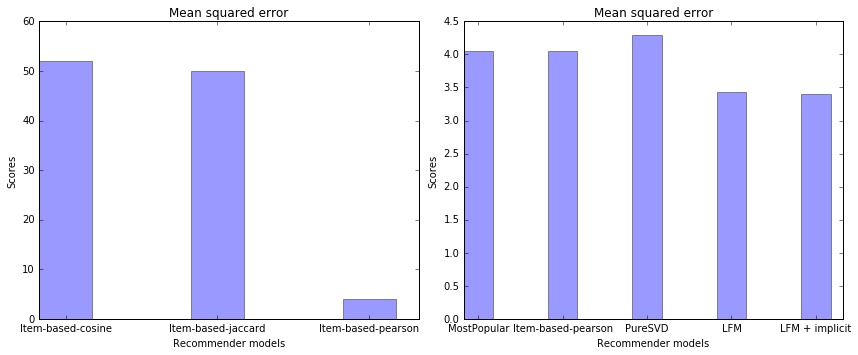

In [133]:
plt.figure(figsize=(12,5))
plt.subplot (1, 2, 1)
n_models = 3

MSE_result = (52, 50, 4.05)
index = np.arange(n_models)
opacity = 0.4
bar_width = 0.35
rects1 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity)

plt.xlabel('Recommender models')
plt.ylabel('Scores')
plt.title('Mean squared error')
plt.xticks(index + bar_width / 2, ('Item-based-cosine', 'Item-based-jaccard', 'Item-based-pearson'))
plt.legend()

plt.tight_layout()

plt.subplot (1, 2, 2)
n_models = 5

MSE_result = (4.05, 4.05, 4.3, 3.43, 3.40)
index = np.arange(n_models)
rects2 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity)

plt.xlabel('Recommender models')
plt.ylabel('Scores')
plt.title('Mean squared error')
plt.xticks(index + bar_width / 2, ('MostPopular', 'Item-based-pearson', 'PureSVD', 'LFM', 'LFM + implicit'))
plt.legend()

plt.tight_layout()

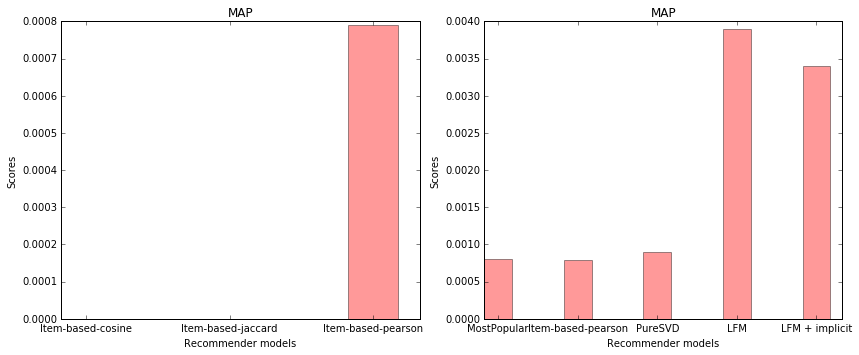

In [317]:
plt.figure(figsize=(12,5))
plt.subplot (1, 2, 1)
n_models = 3

MSE_result = (0, 0, 0.00079)
index = np.arange(n_models)
opacity = 0.4
bar_width = 0.35
rects1 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity, color = 'r')

plt.xlabel('Recommender models')
plt.ylabel('Scores')
plt.title('MAP')
plt.xticks(index + bar_width / 2, ('Item-based-cosine', 'Item-based-jaccard', 'Item-based-pearson'))
plt.legend()

plt.tight_layout()

plt.subplot (1, 2, 2)
n_models = 5

MSE_result = (0.0008, 0.00079, 0.0009, 0.0039, 0.0034)
index = np.arange(n_models)
rects2 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity, color = 'r')

plt.xlabel('Recommender models')
plt.ylabel('Scores')
plt.title('MAP')
plt.xticks(index + bar_width / 2, ('MostPopular', 'Item-based-pearson', 'PureSVD', 'LFM', 'LFM + implicit'))
plt.legend()

plt.tight_layout()

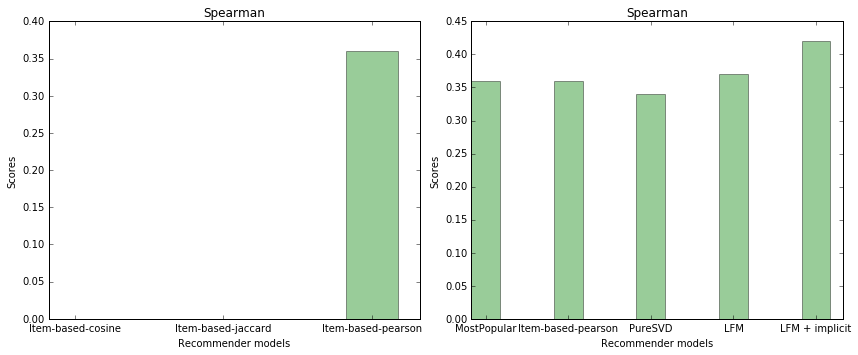

In [318]:
plt.figure(figsize=(12,5))
plt.subplot (1, 2, 1)
n_models = 3

MSE_result = (0, 0, 0.36)
index = np.arange(n_models)
opacity = 0.4
bar_width = 0.35
rects1 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity, color = 'g')

plt.xlabel('Recommender models')
plt.ylabel('Scores')
plt.title('Spearman')
plt.xticks(index + bar_width / 2, ('Item-based-cosine', 'Item-based-jaccard', 'Item-based-pearson'))
plt.legend()

plt.tight_layout()

plt.subplot (1, 2, 2)
n_models = 5

MSE_result = (0.36, 0.36, 0.34, 0.37, 0.42)
index = np.arange(n_models)
rects2 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity, color = 'g')

plt.xlabel('Recommender models')
plt.ylabel('Scores')
plt.title('Spearman')
plt.xticks(index + bar_width / 2, ('MostPopular', 'Item-based-pearson', 'PureSVD', 'LFM', 'LFM + implicit'))
plt.legend()

plt.tight_layout()

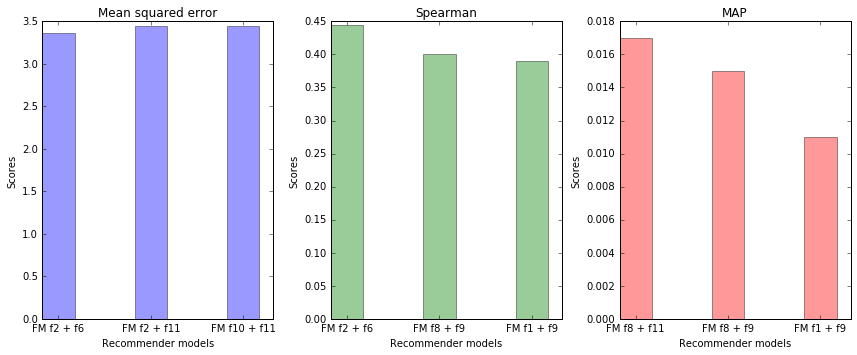

In [322]:
plt.figure(figsize=(12,5))
n_models = 3

plt.subplot (1, 3, 1)
MSE_result = (3.36, 3.45, 3.45)
index = np.arange(n_models)
opacity = 0.4
bar_width = 0.35
rects1 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity)

plt.xlabel('Recommender models')
plt.ylabel('Scores')
plt.title('Mean squared error')
plt.xticks(index + bar_width / 2, ('FM f2 + f6', 'FM f2 + f11', 'FM f10 + f11'))
plt.legend()

plt.tight_layout()

plt.subplot (1, 3, 2)
MSE_result = (0.444, 0.40, 0.39)
index = np.arange(n_models)
opacity = 0.4
bar_width = 0.35
rects1 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity, color = 'g')

plt.xlabel('Recommender models')
plt.ylabel('Scores')
plt.title('Spearman')
plt.xticks(index + bar_width / 2, ('FM f2 + f6', 'FM f8 + f9', 'FM f1 + f9'))
plt.legend()

plt.tight_layout()

plt.subplot (1, 3, 3)
MSE_result = (0.017, 0.015, 0.011)
index = np.arange(n_models)
opacity = 0.4
bar_width = 0.35
rects1 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity, color = 'r')

plt.xlabel('Recommender models')
plt.ylabel('Scores')
plt.title('MAP')
plt.xticks(index + bar_width / 2, ('FM f8 + f11', 'FM f8 + f9', 'FM f1 + f9'))
plt.legend()

plt.tight_layout()

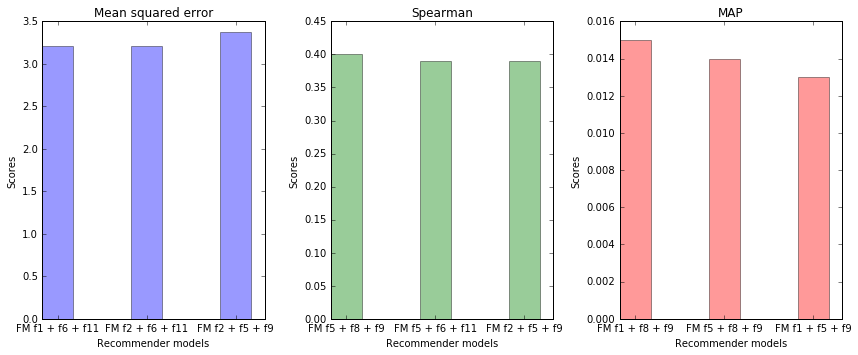

In [320]:
plt.figure(figsize=(12,5))
n_models = 3

plt.subplot (1, 3, 1)
MSE_result = (3.21, 3.21, 3.38)
index = np.arange(n_models)
opacity = 0.4
bar_width = 0.35
rects1 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity)

plt.xlabel('Recommender models')
plt.ylabel('Scores')
plt.title('Mean squared error')
plt.xticks(index + bar_width / 2, ('FM f1 + f6 + f11', 'FM f2 + f6 + f11', 'FM f2 + f5 + f9'))
plt.legend()

plt.tight_layout()

plt.subplot (1, 3, 2)
MSE_result = (0.40, 0.39, 0.39)
index = np.arange(n_models)
opacity = 0.4
bar_width = 0.35
rects1 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity, color = 'g')

plt.xlabel('Recommender models')
plt.ylabel('Scores')
plt.title('Spearman')
plt.xticks(index + bar_width / 2, ('FM f5 + f8 + f9', 'FM f5 + f6 + f11', 'FM f2 + f5 + f9'))
plt.legend()

plt.tight_layout()

plt.subplot (1, 3, 3)
MSE_result = (0.015, 0.014, 0.013)
index = np.arange(n_models)
opacity = 0.4
bar_width = 0.35
rects1 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity, color = 'r')

plt.xlabel('Recommender models')
plt.ylabel('Scores')
plt.title('MAP')
plt.xticks(index + bar_width / 2, ('FM f1 + f8 + f9', 'FM f5 + f8 + f9', 'FM f1 + f5 + f9'))
plt.legend()

plt.tight_layout()

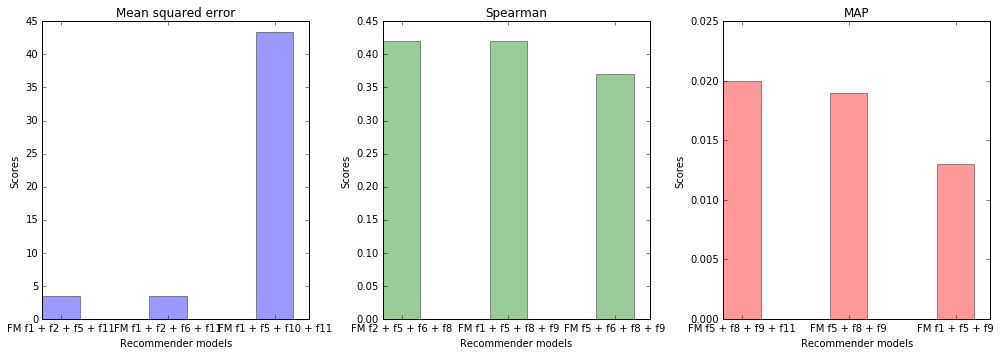

In [325]:
plt.figure(figsize=(14,5))
n_models = 3

plt.subplot (1, 3, 1)
MSE_result = (3.46, 3.51, 43.38)
index = np.arange(n_models)
opacity = 0.4
bar_width = 0.35
rects1 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity)

plt.xlabel('Recommender models')
plt.ylabel('Scores')
plt.title('Mean squared error')
plt.xticks(index + bar_width / 2, ('FM f1 + f2 + f5 + f11', 'FM f1 + f2 + f6 + f11', 'FM f1 + f5 + f10 + f11'))
plt.legend()

plt.tight_layout()

plt.subplot (1, 3, 2)
MSE_result = (0.42, 0.42, 0.37)
index = np.arange(n_models)
opacity = 0.4
bar_width = 0.35
rects1 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity, color = 'g')

plt.xlabel('Recommender models')
plt.ylabel('Scores')
plt.title('Spearman')
plt.xticks(index + bar_width / 2, ('FM f2 + f5 + f6 + f8', 'FM f1 + f5 + f8 + f9', 'FM f5 + f6 + f8 + f9'))
plt.legend()

plt.tight_layout()

plt.subplot (1, 3, 3)
MSE_result = (0.02, 0.019, 0.013)
index = np.arange(n_models)
opacity = 0.4
bar_width = 0.35
rects1 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity, color = 'r')

plt.xlabel('Recommender models')
plt.ylabel('Scores')
plt.title('MAP')
plt.xticks(index + bar_width / 2, ('FM f5 + f8 + f9 + f11', 'FM f5 + f8 + f9', 'FM f1 + f5 + f9'))
plt.legend()

plt.tight_layout()

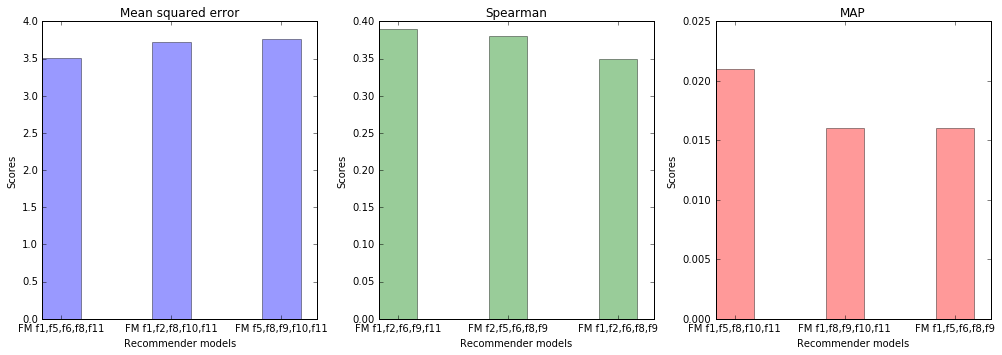

In [326]:
plt.figure(figsize=(14,5))
n_models = 3

plt.subplot (1, 3, 1)
MSE_result = (3.51, 3.72, 3.76)
index = np.arange(n_models)
opacity = 0.4
bar_width = 0.35
rects1 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity)

plt.xlabel('Recommender models')
plt.ylabel('Scores')
plt.title('Mean squared error')
plt.xticks(index + bar_width / 2, ('FM f1,f5,f6,f8,f11', 'FM f1,f2,f8,f10,f11', 'FM f5,f8,f9,f10,f11'))
plt.legend()

plt.tight_layout()

plt.subplot (1, 3, 2)
MSE_result = (0.39, 0.38, 0.35)
index = np.arange(n_models)
opacity = 0.4
bar_width = 0.35
rects1 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity, color = 'g')

plt.xlabel('Recommender models')
plt.ylabel('Scores')
plt.title('Spearman')
plt.xticks(index + bar_width / 2, ('FM f1,f2,f6,f9,f11', 'FM f2,f5,f6,f8,f9', 'FM f1,f2,f6,f8,f9'))
plt.legend()

plt.tight_layout()

plt.subplot (1, 3, 3)
MSE_result = (0.021, 0.016, 0.016)
index = np.arange(n_models)
opacity = 0.4
bar_width = 0.35
rects1 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity, color = 'r')

plt.xlabel('Recommender models')
plt.ylabel('Scores')
plt.title('MAP')
plt.xticks(index + bar_width / 2, ('FM f1,f5,f8,f10,f11', 'FM f1,f8,f9,f10,f11', 'FM f1,f5,f6,f8,f9'))
plt.legend()

plt.tight_layout()

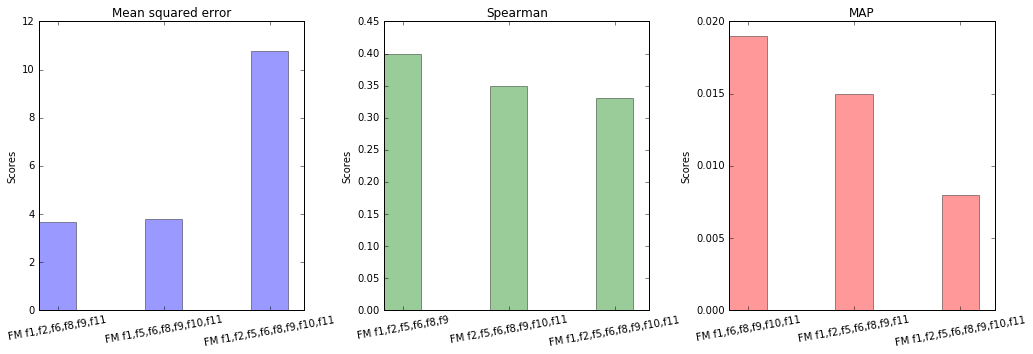

In [327]:
plt.figure(figsize=(14,5))
n_models = 3

plt.subplot (1, 3, 1)
MSE_result = (3.68, 3.78, 10.76)
index = np.arange(n_models)
opacity = 0.4
bar_width = 0.35
rects1 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity)

plt.ylabel('Scores')
plt.title('Mean squared error')
plt.xticks(index + bar_width / 2, ('FM f1,f2,f6,f8,f9,f11', 'FM f1,f5,f6,f8,f9,f10,f11', 'FM f1,f2,f5,f6,f8,f9,f10,f11'), rotation=10)
plt.legend()

plt.tight_layout()

plt.subplot (1, 3, 2)
MSE_result = (0.40, 0.35, 0.33)
index = np.arange(n_models)
opacity = 0.4
bar_width = 0.35
rects1 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity, color = 'g')

plt.ylabel('Scores')
plt.title('Spearman')
plt.xticks(index + bar_width / 2, ('FM f1,f2,f5,f6,f8,f9', 'FM f2,f5,f6,f8,f9,f10,f11', 'FM f1,f2,f5,f6,f8,f9,f10,f11'), rotation=10)
plt.legend()

plt.tight_layout()

plt.subplot (1, 3, 3)
MSE_result = (0.019, 0.015, 0.008)
index = np.arange(n_models)
opacity = 0.4
bar_width = 0.35
rects1 = plt.bar(index, MSE_result, bar_width,
                 alpha=opacity, color = 'r')

plt.ylabel('Scores')
plt.title('MAP')
plt.xticks(index + bar_width / 2, ('FM f1,f6,f8,f9,f10,f11', 'FM f1,f2,f5,f6,f8,f9,f11', 'FM f1,f2,f5,f6,f8,f9,f10,f11'), rotation=10)
plt.legend()